NO SE USA MACHINE LEARNING, SE USA PROPIEDADES DEL VALOR MEDIO ESPERADO PERO EN NINGUN MOMENTO SE EJECUTA EL CIRCUITO

In [13]:
#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

# Parametros
from qiskit.circuit import ParameterVector
from qiskit.circuit import Parameter
from qiskit.circuit import ParameterExpression

#ML
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import L_BFGS_B

#Numpy y math
import math
import matplotlib.pyplot as plt
import numpy as np

# pytorch
import torch

In [14]:
def rotation_m(a):
    diag = a
    off_diag = (1 - a**2) ** (1 / 2) * 1j
    W = [[diag, off_diag], [off_diag, diag]]

    return W

In [15]:
def QSP_circ(phi, W):
    
    circ = QuantumCircuit(1)
    circ.h(0)
    for angle in phi[:-1]:
        circ.rz(angle, 0)
        circ.append(Operator(rotation_m(W)),[0])

    circ.rz(phi[-1], 0)  # final rotation
    circ.h(0)  # change of basis |+> , |->
    return circ

In [16]:
def QSP_circ_GateDecompose(phi, W):
    
    circ = QuantumCircuit(1)
    circ.h(0)
    for angle in phi[:-1]:
        circ.rz(angle, 0)
        circ.rz(math.pi/2,0)
        circ.ry(2*math.acos(W),0)
        circ.rz(-math.pi/2,0)

    circ.rz(phi[-1], 0)  # final rotation
    circ.h(0)  # change of basis |+> , |->
    return circ

In [17]:
Operator(rotation_m(1/2))

Operator([[0.5+0.j       , 0. +0.8660254j],
          [0. +0.8660254j, 0.5+0.j       ]],
         input_dims=(2,), output_dims=(2,))

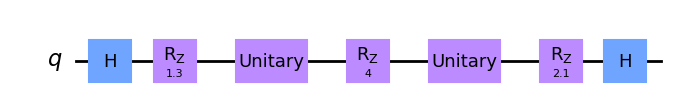

In [18]:
cirz = QSP_circ([1.3,4,2.1] , np.array(1/2) )
cirz.draw('mpl')

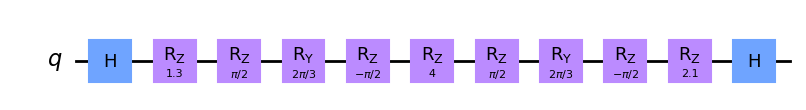

In [19]:
cirz = QSP_circ_GateDecompose([1.3,4,2.1] , np.array(1/2) )
cirz.draw('mpl')

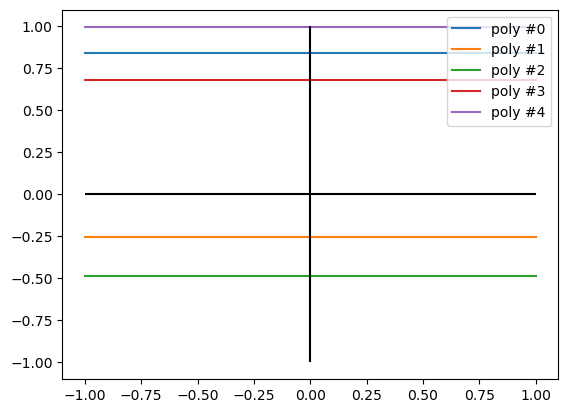

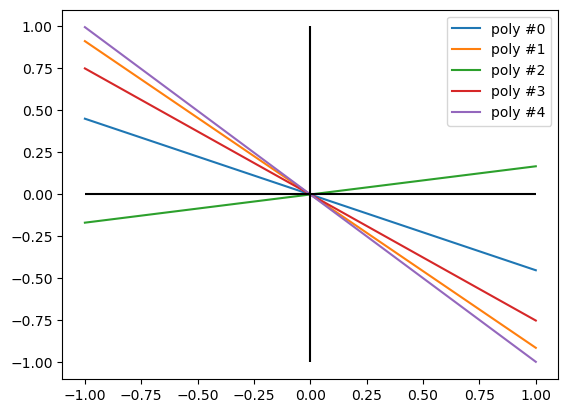

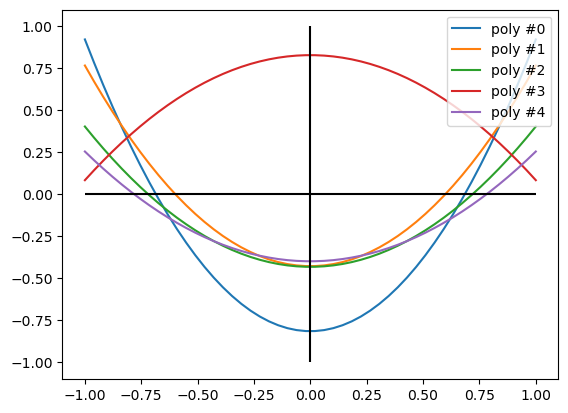

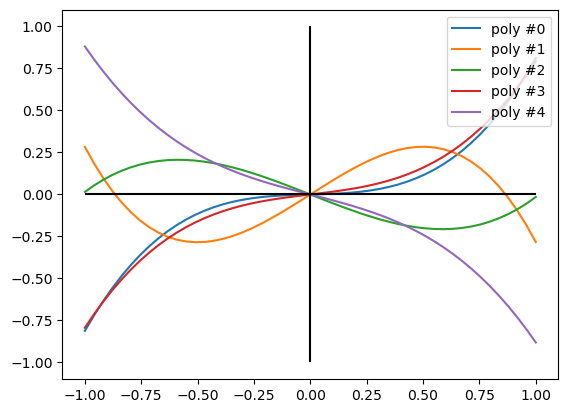

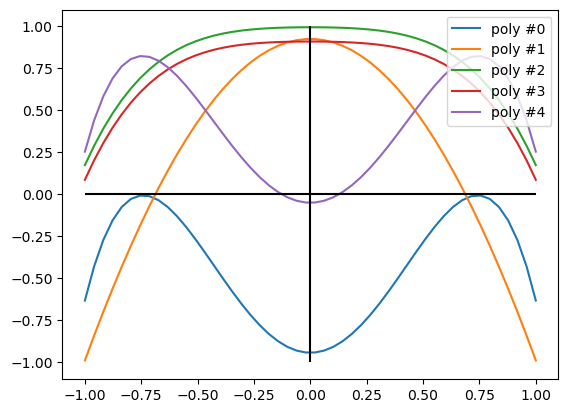

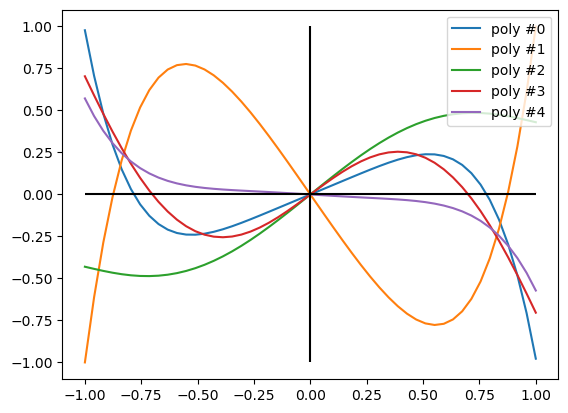

In [20]:
d=5
nPolis=5

a_vals = np.linspace(-1, 1, 50)
phi = np.linspace(-1,1,50)
w_mats = a_vals

np.random.seed(444422)

for j in range(d+1):
    for i in range(nPolis):
        phi = np.random.rand(j+1) * 2 * math.pi
        y_vals = []
        for w in w_mats:
            a=Operator(QSP_circ(phi,w)).data[0,0].real
            y_vals.append(a)
            
        plt.plot(a_vals, y_vals, label=f"poly #{i}")

    plt.vlines(0.0, -1.0, 1.0, color="black")
    plt.hlines(0.0, -1.0, 1.0, color="black")
    plt.legend(loc=1)
    plt.show()

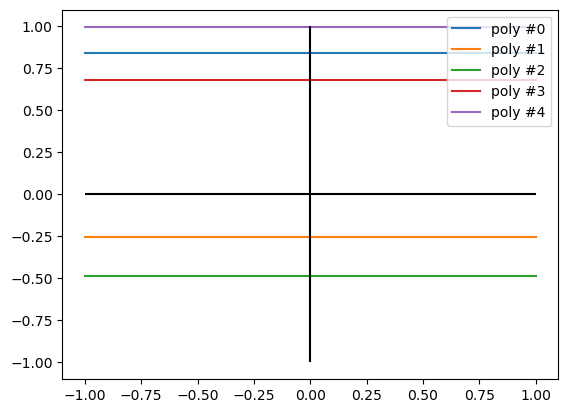

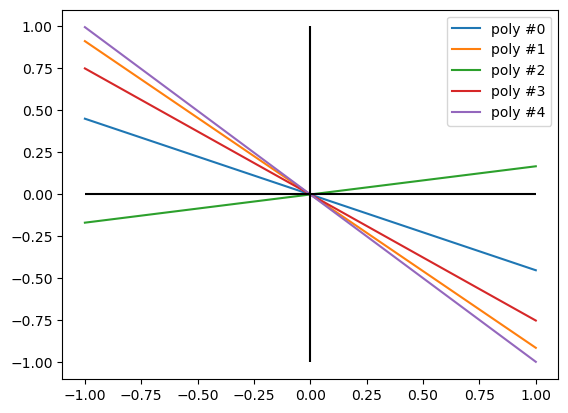

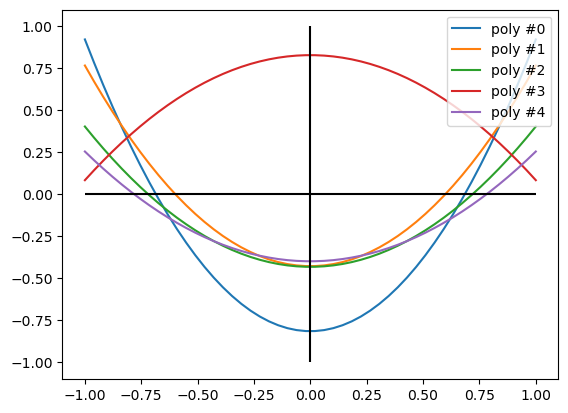

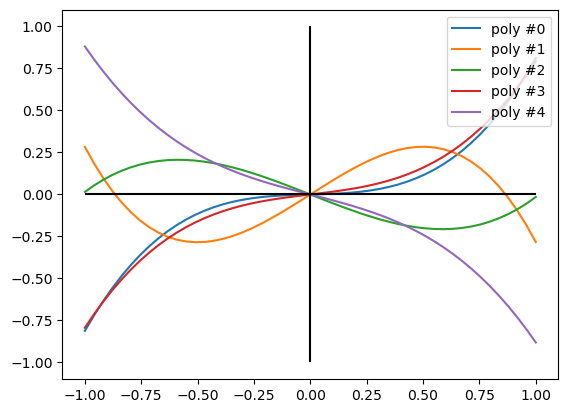

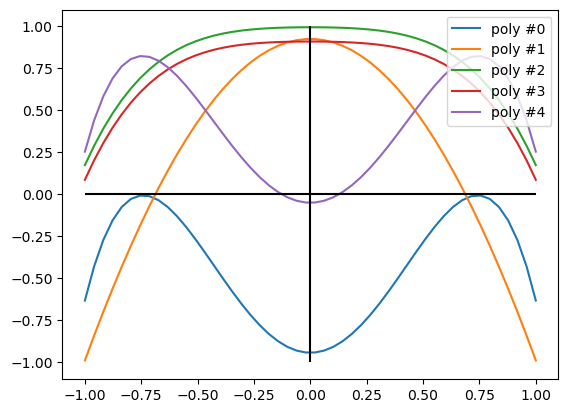

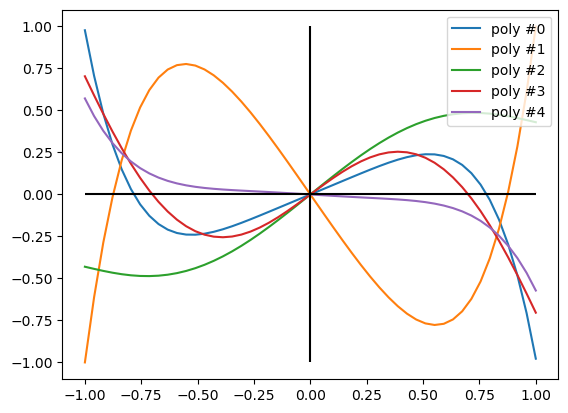

In [21]:
d=5
nPolis=5

a_vals = np.linspace(-1, 1, 50)
phi = np.linspace(-1,1,50)
w_mats = a_vals

np.random.seed(444422)

for j in range(d+1):
    for i in range(nPolis):
        phi = np.random.rand(j+1) * 2 * math.pi
        #print(phi)
        y_vals = []
        for w in w_mats:
            a=Operator(QSP_circ_GateDecompose(phi,w)).data[0,0].real
            y_vals.append(a)
            
        plt.plot(a_vals, y_vals, label=f"poly #{i}")

    plt.vlines(0.0, -1.0, 1.0, color="black")
    plt.hlines(0.0, -1.0, 1.0, color="black")
    plt.legend(loc=1)
    plt.show()

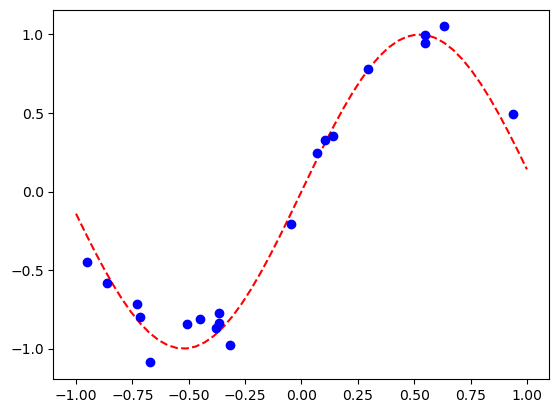

In [22]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(3*x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [23]:
def QSP_circ_parameter(phi, W):
    
    circ = QuantumCircuit(1)
    circ.h(0)
    for angle in phi[:-1]:
        circ.rz(angle, 0)
        circ.rz(math.pi/2,0)
        circ.ry(2*W.arccos(),0)
        circ.rz(-math.pi/2,0)

    circ.rz(phi[-1], 0)  # final rotation
    circ.h(0)  # change of basis |+> , |->
    return circ

In [76]:
torch_pi = torch.Tensor([math.pi])


class QSP_Func_Fit(torch.nn.Module):
    def __init__(self, degree, num_vals, random_seed=None):
        """Given the degree and number of samples, this method randomly
        initializes the parameter vector (randomness can be set by random_seed)
        """
        super().__init__()
        if random_seed is None:
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True)

        else:
            gen = torch.Generator()
            gen.manual_seed(random_seed)
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True, generator=gen)

        self.phi = torch.nn.Parameter(self.phi)
        self.num_phi = degree + 1
        self.num_vals = num_vals

    def forward(self, omega_mats):
        """PennyLane forward implementation"""
        y_pred = []

        for w in omega_mats:
            P_a = Operator(QSP_circ_GateDecompose(phi,w)).data[0,0].real # Taking the (0,0) entry of the matrix corresponds to <0|U|0> 
            y_pred.append(P_a.real)
        
        return torch.autograd.Variable(torch.from_numpy(np.array(y_pred)))

In [77]:
class Model_Runner:
    def __init__(self, model, degree, num_samples, x_vals, y_true):
        """Given a model and a series of model specific arguments, store everything in
        internal attributes.
        """
        self.model = model
        self.degree = degree
        self.num_samples = num_samples

        self.x_vals = x_vals
        self.y_true = y_true

    def execute(
        self, random_seed=13_02_1967, max_shots=25000, verbose=True
    ):  # easter egg: oddly specific seed?
        """Run the optimization protocol on the model using Mean Square Error as a loss
        function and using stochastic gradient descent as the optimizer.
        """
        model = self.model(degree=self.degree, num_vals=self.num_samples, random_seed=random_seed)

        criterion = torch.nn.MSELoss(reduction="sum")
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

        t = 0
        loss_val = 1.0

        while (t <= max_shots) and (loss_val > 0.5):
            
            self.y_pred = model(self.x_vals.numpy())
            print(self.y_pred + 0)
            if t == 1:
                self.init_y_pred = self.y_pred

            # Compute and print loss
            loss = criterion(self.y_pred, self.y_true)
            loss_val = loss.item()

            if (t % 1000 == 0) and verbose:
                print(f"---- iter: {t}, loss: {round(loss_val, 4)} -----")

            # Perform a backward pass and update weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t += 1

        self.model_params = model.phi

    def plot_result(self, show=True):
        """Plot the results"""
        plt.plot(self.x_vals, self.y_true.tolist(), "--b", label="target func")
        plt.plot(self.x_vals, self.y_pred.tolist(), ".g", label="optim params")
        plt.plot(self.x_vals, self.init_y_pred.tolist(), ".r", label="init params")
        plt.legend(loc=1)

        if show:
            plt.show()

In [79]:
d = 9  # dim(phi) = d + 1,
num_samples = 50


def custom_poly(x):
    """A custom polynomial of degree <= d and parity d % 2"""
    return torch.tensor(4 * x**5 - 5 * x**3 + x, requires_grad=False, dtype=torch.float)


a_vals = torch.linspace(-1, 1, num_samples)
y_true = custom_poly(a_vals)

qsp_model_runner = Model_Runner(QSP_Func_Fit, d, num_samples, a_vals, y_true)

qsp_model_runner.execute()
qsp_model_runner.plot_result()

tensor([ 0.5717,  0.4666,  0.3787,  0.3057,  0.2456,  0.1966,  0.1570,  0.1254,
         0.1005,  0.0810,  0.0659,  0.0544,  0.0456,  0.0389,  0.0337,  0.0295,
         0.0261,  0.0231,  0.0202,  0.0174,  0.0145,  0.0115,  0.0083,  0.0050,
         0.0017, -0.0017, -0.0050, -0.0083, -0.0115, -0.0145, -0.0174, -0.0202,
        -0.0231, -0.0261, -0.0295, -0.0337, -0.0389, -0.0456, -0.0544, -0.0659,
        -0.0810, -0.1005, -0.1254, -0.1570, -0.1966, -0.2456, -0.3057, -0.3787,
        -0.4666, -0.5717], dtype=torch.float64)
---- iter: 0, loss: 1.9369 -----


/tmp/ipykernel_23749/3592535443.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(4 * x**5 - 5 * x**3 + x, requires_grad=False, dtype=torch.float)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Intentos De Cohesionar, como nuestro observable es la red No sirve hacer el TorchConnector de qiskit

In [27]:
max_grad_pol = 5

param_x = ParameterVector("x",1)
param_y = ParameterVector("weights", max_grad_pol+1)

circ = QSP_circ_parameter(param_y, param_x[0])
observable1 = SparsePauliOp.from_list([("X" * circ.num_qubits, 1)])

In [28]:
circ.draw()

┌───┐┌────────────────┐┌─────────┐┌──────────────────┐┌──────────┐»
q: ┤ H ├┤ Rz(weights[0]) ├┤ Rz(π/2) ├┤ Ry(2*acos(x[0])) ├┤ Rz(-π/2) ├»
   └───┘└────────────────┘└─────────┘└──────────────────┘└──────────┘»
«   ┌────────────────┐┌─────────┐┌──────────────────┐┌──────────┐»
«q: ┤ Rz(weights[1]) ├┤ Rz(π/2) ├┤ Ry(2*acos(x[0])) ├┤ Rz(-π/2) ├»
«   └────────────────┘└─────────┘└──────────────────┘└──────────┘»
«   ┌────────────────┐┌─────────┐┌──────────────────┐┌──────────┐»
«q: ┤ Rz(weights[2]) ├┤ Rz(π/2) ├┤ Ry(2*acos(x[0])) ├┤ Rz(-π/2) ├»
«   └────────────────┘└─────────┘└──────────────────┘└──────────┘»
«   ┌────────────────┐┌─────────┐┌──────────────────┐┌──────────┐»
«q: ┤ Rz(weights[3]) ├┤ Rz(π/2) ├┤ Ry(2*acos(x[0])) ├┤ Rz(-π/2) ├»
«   └────────────────┘└─────────┘└──────────────────┘└──────────┘»
«   ┌────────────────┐┌─────────┐┌──────────────────┐┌──────────┐»
«q: ┤ Rz(weights[4]) ├┤ Rz(π/2) ├┤ Ry(2*acos(x[0])) ├┤ Rz(-π/2) ├»
«   └────────────────┘└─────────┘└──────────────────┘└──────────┘»
«   ┌────────────────┐┌───┐
«q: ┤ Rz(weights[5]) ├┤ H ├
«   └────────────────┘└───┘

In [29]:
qnn = EstimatorQNN(circuit=circ, input_params=param_x, weight_params=param_y, observables=observable1)


initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights)

regressor = NeuralNetworkRegressor(
    neural_network=qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=20000)
)

[[-0.45896807]]
[[-0.44485348]]
[[-0.42999787]]
[[-0.414426]]
[[-0.39816381]]
[[-0.38123837]]
[[-0.36367789]]
[[-0.34551162]]
[[-0.32676981]]
[[-0.30748369]]
[[-0.28768538]]
[[-0.26740787]]
[[-0.24668492]]
[[-0.22555105]]
[[-0.20404148]]
[[-0.18219203]]
[[-0.16003909]]
[[-0.13761957]]
[[-0.11497081]]
[[-0.09213054]]
[[-0.0691368]]
[[-0.0460279]]
[[-0.02284233]]
[[0.0003813]]
[[0.02360428]]
[[0.04678795]]
[[0.06989368]]
[[0.09288299]]
[[0.11571757]]
[[0.13835941]]
[[0.16077077]]
[[0.18291432]]
[[0.20475319]]
[[0.226251]]
[[0.24737193]]
[[0.2680808]]
[[0.28834312]]
[[0.30812513]]
[[0.32739389]]
[[0.34611729]]
[[0.36426415]]
[[0.38180424]]
[[0.39870834]]
[[0.4149483]]
[[0.43049707]]
[[0.44532873]]
[[0.4594186]]
[[0.47274319]]
[[0.48528031]]
[[0.49700908]]


<function matplotlib.pyplot.show(close=None, block=None)>

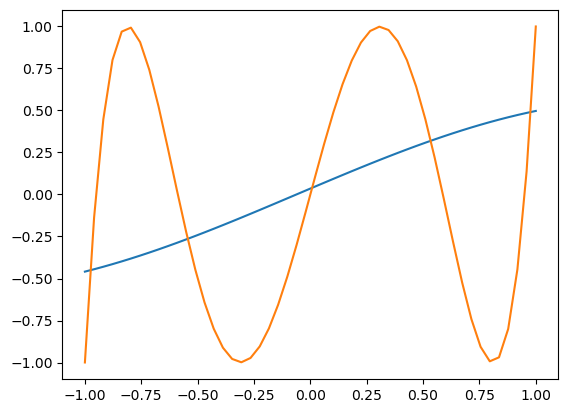

In [30]:
model.forward(Tensor([0]))
y_vals = []
z_vals = []
for w in X_:
    a=qnn.forward(w,initial_weights)
    print(a)
    y_vals.append(a.item())
    a=Operator(QSP_circ_GateDecompose(initial_weights,w)).data[0,0].real
    z_vals.append(a.item())
plt.plot(X_, y_vals, label=f"poly final")
plt.plot(X_, z_vals, label=f"poly no")
plt.show

In [16]:
qnn.forward(1,[1.66169731,1.24531721,5.13485971,2.81372008,2.37127813,4.04173727])

QiskitMachineLearningError: 'Estimator job failed.'

In [ ]:
# plot target function
plt.plot(X_, f(X_), "r--", label="target")

# plot data
plt.plot(X, y, "bo", label="sample")

# plot fitted line
y_vals = []
for w in X_:
    a=Operator(QSP_circ_GateDecompose(regressor.weights,w)).data[0,0].real
    y_vals.append(a)
plt.plot(X_, y_vals, label=f"poly final")

y_vals = []
for w in X_:
    a=Operator(QSP_circ_GateDecompose(initial_weights,w)).data[0,0].real
    y_vals.append(a)
plt.plot(X_, y_vals, label=f"poly init")

y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.legend()
plt.show()

In [ ]:
initial_weights

In [ ]:
# Define optimizer and loss function
optimizer = LBFGS(model.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)

In [ ]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()